In [1]:
import loaddata as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [2]:
mj = ld.load_mojo_data()
mc = ld.load_mc_data()
mj_df = pd.DataFrame(mj)
mc_df = ld.to_df(mc)


In [31]:
mc_df['ltitle'] = mc_df['title'].map(lambda x: x.lower())
mj_df['ltitle'] = mc_df['title'].map(lambda x: x.lower())
df = pd.merge(mc_df, mj_df, how = 'inner', on=['title', 'year'])

In [32]:
df.sort('opening_weekend_take', ascending = False)

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,complete,director_x,metacritic_page,metascore,num_user_ratings,rating,release_date,runtime_minutes,studio,title,...,domestic_gross,mojo_slug,opening_per_theater,opening_weekend_take,production_budget,release_date_limited,release_date_wide,widest_release,worldwide_gross,ltitle_y
973,True,Shane Black,/movie/iron-man-3,62.0,1705.0,PG-13,2013-05-03,130.0,Walt Disney Studios Motion Pictures,Iron Man 3,...,409013994.0,ironman3,40946.0,174144585.0,200000000.0,None,2013-05-03,4253.0,1.215440e+09,i saw the devil
1801,True,Christopher Nolan,/movie/the-dark-knight,82.0,4002.0,PG-13,2008-07-18,152.0,Warner Bros. Pictures,The Dark Knight,...,534858444.0,darkknight,36283.0,158411483.0,185000000.0,None,2008-07-18,4366.0,1.004558e+09,coming to america
1894,True,Gary Ross,/movie/the-hunger-games,67.0,1562.0,PG-13,2012-03-23,142.0,Lionsgate,The Hunger Games,...,408010692.0,hungergames,36871.0,152535747.0,78000000.0,None,2012-03-23,4137.0,6.912478e+08,hellboy ii: the golden army
972,True,Jon Favreau,/movie/iron-man-2,57.0,721.0,PG-13,2010-05-07,124.0,Paramount Pictures,Iron Man 2,...,312433331.0,ironman2,29252.0,128122480.0,200000000.0,None,2010-05-07,4390.0,6.239333e+08,"i, robot"
2192,True,Lee Unkrich,/movie/toy-story-3,92.0,1283.0,G,2010-06-18,103.0,Walt Disney Studios Motion Pictures,Toy Story 3,...,415004880.0,toystory3,27385.0,110307189.0,200000000.0,None,2010-06-18,4028.0,1.063172e+09,take shelter
1579,True,Andrew Adamson,/movie/shrek-2,75.0,358.0,PG,2004-05-19,93.0,DreamWorks Distribution,Shrek 2,...,441226247.0,shrek2,25951.0,108037878.0,150000000.0,None,2004-05-19,4223.0,9.198388e+08,scary movie
974,True,Jon Favreau,/movie/iron-man,79.0,1105.0,PG-13,2008-05-02,126.0,Paramount Pictures,Iron Man,...,318412101.0,ironman,24024.0,98618668.0,140000000.0,None,2008-05-02,4154.0,5.851742e+08,i origins
1970,True,Andy Wachowski,/movie/the-matrix-reloaded,62.0,657.0,R,2003-05-15,138.0,Warner Bros. Pictures,The Matrix Reloaded,...,281576461.0,matrixreloaded,25471.0,91774413.0,150000000.0,None,2003-05-15,3603.0,7.421285e+08,the lone ranger
139,True,Clint Eastwood,/movie/american-sniper,72.0,662.0,R,2014-12-25,132.0,Warner Bros. Pictures,American Sniper,...,347251832.0,americansniper,25111.0,89269066.0,58800000.0,2014-12-25,2015-01-16,3885.0,5.406518e+08,ace ventura: pet detective
675,True,Justin Lin,/movie/fast-five,67.0,487.0,PG-13,2011-04-29,130.0,Universal Pictures,Fast Five,...,209837675.0,fastfive,23655.0,86198765.0,125000000.0,None,2011-04-29,3793.0,6.261377e+08,el sicario: room 164


In [33]:
df_clean = df[df.complete == True]

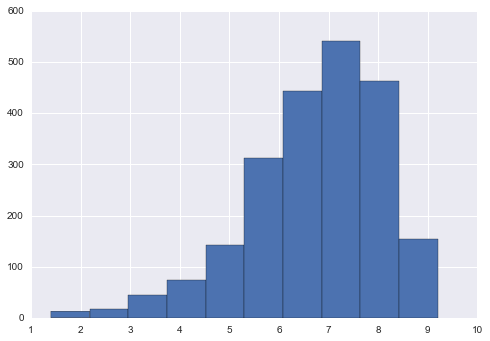

In [34]:
df_clean['user_score'].hist()

In [36]:
#df_clean['user_score'].describe()
#df_clean.isnull().sum()

df_model = df_clean.dropna(subset = ['domestic_gross', 'opening_per_theater', 'opening_weekend_take', 'release_date_wide', 'widest_release'])

In [45]:
df_model = df_model[df_model['year'] >= 2005]

In [49]:
df_model.groupby(by = 'studio').average()

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


,complete,director_x,metacritic_page,metascore,num_user_ratings,rating,release_date,runtime_minutes,title,user_score,...,domestic_gross,mojo_slug,opening_per_theater,opening_weekend_take,production_budget,release_date_limited,release_date_wide,widest_release,worldwide_gross,ltitle_y
studio,,,,,,,,,,,,,,,,,,,,,
,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,1,0,7,7,5,7
"""DIA"" Productions GmbH & Co. KG",1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
20th Century Fox Home Entertainment,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
518 Media,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
A24,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,3,5,11,11,11,11
ABKCO Films,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
ARC Entertainment (II),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
ATO Pictures,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,0,0,4,4,2,4
Abramorama,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,0,0,4,4,1,4


In [50]:
df_model['growth_factor'] = df_model['domestic_gross'] / df['opening_weekend_take']

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
df_model[['growth_factor', 'title', 'metascore']].sort('growth_factor', ascending = False)

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,growth_factor,title,metascore
599,302.777686,Downfall,82.0
442,208.463361,City Island,66.0
2009,157.782700,The Painted Veil,69.0
1319,152.500331,Once,88.0
1536,134.607815,Searching for Sugar Man,79.0
1174,126.136619,Me and You and Everyone We Know,76.0
1361,124.847816,"Paris, je t'aime",66.0
1937,123.210687,The Last King of Scotland,74.0
1897,117.079992,The Hurt Locker,94.0
960,108.772857,Inside Job,88.0


In [67]:
df_model['opening_theater_count'] = df_model['opening_weekend_take'] / df_model['opening_per_theater'] 

c:\Users\JBK988\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
ratings = pd.get_dummies(df_model['rating'])
df_model = pd.merge(df_model, ratings, left_index = True, right_index = True)

In [151]:
df_model['PG-13'] = df_model['PG-13'] + df_model['PG--13']

In [152]:
del df_model['PG--13']

In [74]:
import statsmodels.api as sm
Y = df_model.growth_factor
X = sm.add_constant(df_model[['opening_theater_count', 'opening_per_theater', 'metascore']])

linmodel = sm.OLS(Y,X).fit()

In [72]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          growth_factor   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     224.0
Date:                Thu, 14 Apr 2016   Prob (F-statistic):          1.47e-121
Time:                        15:42:21   Log-Likelihood:                -6777.7
No. Observations:                1624   AIC:                         1.356e+04
Df Residuals:                    1620   BIC:                         1.359e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                    -0.3160      1.574     -0.201      0.841        -3.404     2.772
opening_theater_count    -0.0036      0.000    -12.195      0.000        -0.004    -0.003
opening_per_theater       0.0006   4.28e-05     13.998      0.000         0.001     0.001
metascore                 0.1931      0.024      7.948      0.000         0.145     0.241
==============================================================================
Omnibus:                     2015.326   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           492551.765
Skew:                           6.280   Prob(JB):                         0.00
Kurtosis:                      87.388   Cond. No.                     5.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
df_model['lim_release'] = df_model['release_date_limited'].isnull()
df_full_release = df_model[df_model['lim_release'] == True]
df_lim_release = df_model[df_model['lim_release'] == False]

In [147]:
Y = df_full_release.growth_factor
X = sm.add_constant(df_full_release[['opening_theater_count', 'PG', 'opening_per_theater', 'metascore']])

linmodel = sm.OLS(Y,X).fit()

In [118]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          growth_factor   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     161.5
Date:                Thu, 14 Apr 2016   Prob (F-statistic):          7.47e-115
Time:                        16:16:44   Log-Likelihood:                -6276.6
No. Observations:                1493   AIC:                         1.256e+04
Df Residuals:                    1488   BIC:                         1.259e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                    -1.4293      1.683     -0.849      0.396        -4.731     1.873
opening_theater_count    -0.0038      0.000    -11.939      0.000        -0.004    -0.003
PG                        3.8475      1.345      2.861      0.004         1.209     6.486
opening_per_theater       0.0006   4.54e-05     12.662      0.000         0.000     0.001
metascore                 0.2203      0.027      8.203      0.000         0.168     0.273
==============================================================================
Omnibus:                     1831.713   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           405329.361
Skew:                           6.158   Prob(JB):                         0.00
Kurtosis:                      82.775   Cond. No.                     5.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
float_vals = pd.to_numeric(df_model['year'])

In [128]:
df_model = pd.concat([df_model, float_vals], axis = 1)

In [142]:
del df_model['year']

In [143]:
df_model = pd.concat([df_model, float_vals], axis = 1)

In [153]:
df_model['lim_release'] = df_model['release_date_limited'].isnull()
df_full_release = df_model[df_model['lim_release'] == True]
df_lim_release = df_model[df_model['lim_release'] == False]

In [154]:
Y = df_full_release.growth_factor
X = sm.add_constant(df_full_release[['opening_theater_count', 'year', 'PG-13', 'opening_per_theater', 'metascore']])

linmodel = sm.OLS(Y,X).fit()

In [155]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          growth_factor   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     134.5
Date:                Thu, 14 Apr 2016   Prob (F-statistic):          9.00e-118
Time:                        16:37:02   Log-Likelihood:                -6267.1
No. Observations:                1493   AIC:                         1.255e+04
Df Residuals:                    1487   BIC:                         1.258e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                   923.7215    295.903      3.122      0.002       343.291  1504.152
opening_theater_count    -0.0041      0.000    -12.656      0.000        -0.005    -0.003
year                     -0.4607      0.147     -3.131      0.002        -0.749    -0.172
PG-13                     3.9451      0.961      4.106      0.000         2.060     5.830
opening_per_theater       0.0006   4.52e-05     12.374      0.000         0.000     0.001
metascore                 0.2333      0.027      8.697      0.000         0.181     0.286
==============================================================================
Omnibus:                     1813.434   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           386568.293
Skew:                           6.056   Prob(JB):                         0.00
Kurtosis:                      80.893   Cond. No.                     9.23e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""